# Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

# Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.



# Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.


# Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

In [82]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

# Readind the data set

In [2]:
creditdata = pd.read_csv('creditcard.csv',sep=',')
creditdata.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# EDA

In [3]:
creditdata.isnull().values.any()

False

In [4]:
labels = ['Normal','Fraud']

Text(0, 0.5, 'Frequency')

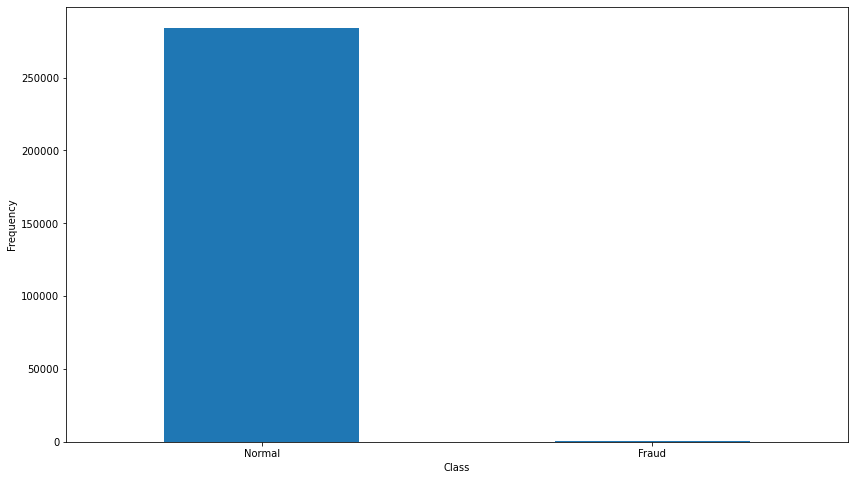

In [5]:
countclass = pd.value_counts(creditdata['Class'])

countclass.plot(kind='bar', rot = 0)

plt.xticks(range(2), labels) # range here nothing but number of labels in list.(range(len(labels)), labels)


plt.xlabel("Class")

plt.ylabel("Frequency")

In [6]:
print("Normal data:", len(creditdata[creditdata.Class ==0]))
print("Fraud data:", len(creditdata[creditdata.Class ==1]))
  

Normal data: 284315
Fraud data: 492


In [7]:
#Gathering a frud and normal datset

fraud_data = creditdata[creditdata.Class ==1]
normal_data = creditdata[creditdata.Class==0]

In [8]:
print(fraud_data.shape, normal_data.shape)

(492, 31) (284315, 31)


# Analyzing the transacton information for fraud and normal data

In [9]:
# for fraud data set 
fraud_data.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
# for normal dataset
normal_data.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

# As we can see that on fraud data transaction amount is very less.

Text(0.5, 0, 'Time (in Seconds)')

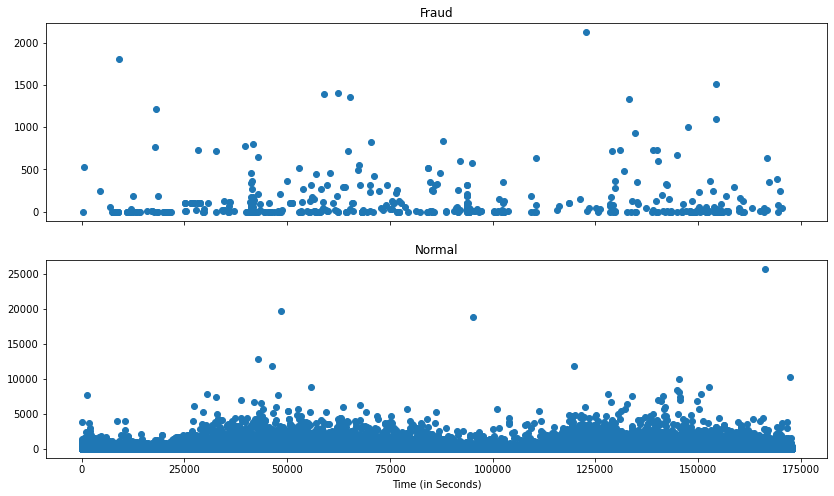

In [11]:
# cheking how the how often the fradulent trasaction happens as compare to normal trasamction

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.scatter(fraud_data.Time, fraud_data.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal_data.Time, normal_data.Amount)
ax2.set_title('Normal')


plt.xlabel('Time (in Seconds)')


this grpah doest show too much information

# Taking the sample data because dataset is too big which will take lot of execution time

In [12]:
creditdata_sample = creditdata.sample(frac=0.1, random_state=1)
creditdata_sample.shape

(28481, 31)

In [23]:
# number of fraud and valid data set.

Fraud_cases = creditdata_sample[creditdata_sample['Class']==1]
Normal_cases = creditdata_sample[creditdata_sample['Class']==0]

In [25]:
# Finding outlier fraction.
outlier_fraction = len(Fraud_cases)/len(Normal_cases)
print(outlier_fraction)
print("Fraud cases:", len(Fraud_cases))
print("Normal cases:", len(Normal_cases))


0.0017234102419808666
Fraud cases: 49
Normal cases: 28432


<AxesSubplot:>

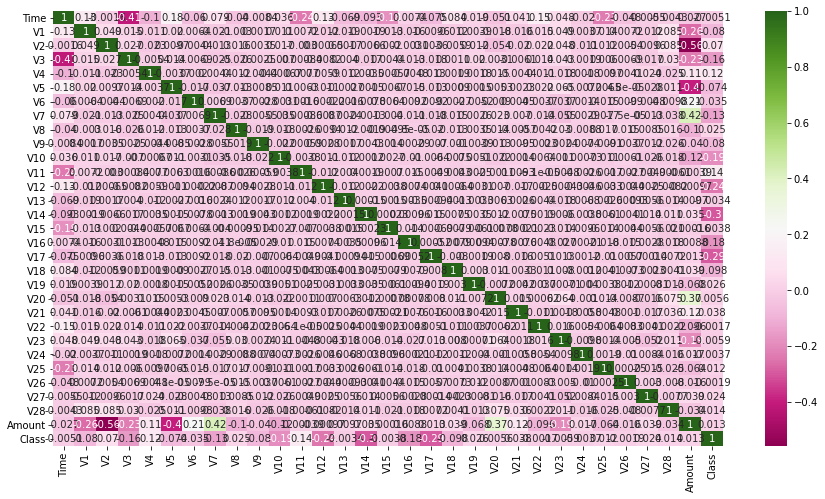

In [28]:
#visualize through heatmap
plt.subplots(figsize=(15,8))
sns.heatmap(creditdata_sample.corr(), annot=True, cmap="PiYG")

# Creating independent and dependent features 

In [30]:
fea = creditdata_sample.drop(['Class'], axis=1)
tar = creditdata_sample.Class

In [32]:
print(fea.shape, tar.shape)

(28481, 30) (28481,)


In [33]:
x = fea
y = tar

# Model prediction 

In [87]:

##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(x), 
                                       contamination=outlier_fraction,random_state=123, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski')
   
}



In [88]:
#n_outliers = len(Fraud_cases)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    if clf_name == "Isolation Forest":
        clf.fit(x)
        scores_prediction = clf.decision_function(x)
        y_pred = clf.predict(x)
        
    elif clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(x)
        scores_prediction = clf.negative_outlier_factor_
        
        #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
        # 1 defines normal and -1 defines fraud in isloation forest as it focus on outliers
    y_pred[y_pred == 1] = 0 #
    y_pred[y_pred == -1] = 1
    
    
    n_errors = (y_pred != y).sum()
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y,y_pred))
    print("Classification Report :")
    print(classification_report(y,y_pred))
    print("-----------------------------------------------------")

Isolation Forest: 73
Accuracy Score :
0.9974368877497279
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

-----------------------------------------------------
Local Outlier Factor: 3251
Accuracy Score :
0.8858537270461009
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     28432
           1       0.00      0.24      0.01        49

    accuracy                           0.89     28481
   macro avg       0.50      0.57      0.47     28481
weighted avg       1.00      0.89      0.94     28481

-----------------------------------------------------


## Observations :
Isolation Forest detected 73 errors versus Local Outlier Factor detecting 3251 errors.

Isolation Forest has a 99.74% more accurate than LOF of 88.58%.
